# **Importing the dependencies**

In [44]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.datasets import mnist #imorting the dataset
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, DepthwiseConv2D
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### Loading the dataset

In [ ]:
# Load mnist dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(f"Training set: {x_train.shape}, Labels: {y_train.shape}")
print(f"Test set: {x_test.shape}, Labels: {y_test.shape}")


Training set: (60000, 28, 28), Labels: (60000,)
Test set: (10000, 28, 28), Labels: (10000,)


### Visualizing sample images



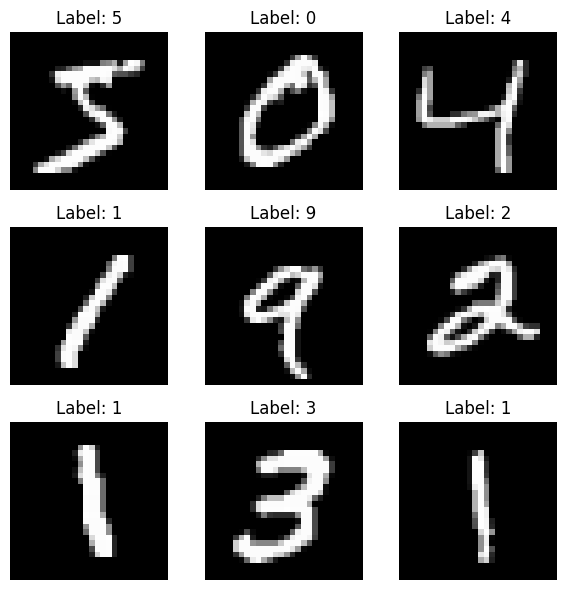

In [ ]:
# Plot the first 9 images
plt.figure(figsize=(6, 6))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


### Check Label Distribution

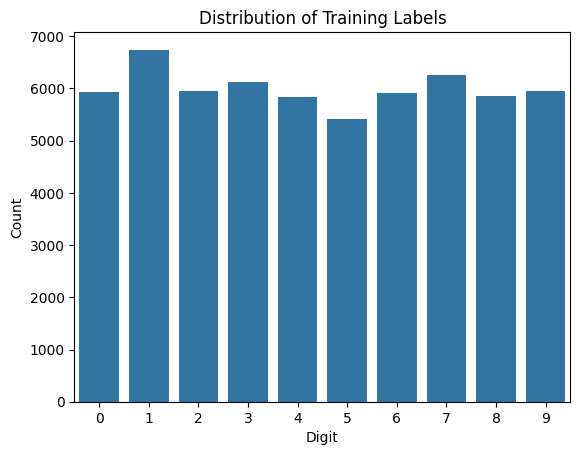

In [ ]:
import seaborn as sns
# Convert labels to Pandas Series for visualization
train_labels_df = pd.Series(y_train)
sns.countplot(x=train_labels_df)
plt.title("Distribution of Training Labels")
plt.xlabel("Digit")
plt.ylabel("Count")
plt.show()


### Check Pixel Value Range and Data Type

In [ ]:
print("Data type:", x_train.dtype)
print("Min pixel value:", x_train.min())
print("Max pixel value:", x_train.max())


Data type: uint8
Min pixel value: 0
Max pixel value: 255


### Check Unique Classes and Shapes

In [ ]:
print("Unique classes:", np.unique(y_train))
print("Number of classes:", len(np.unique(y_train)))


Unique classes: [0 1 2 3 4 5 6 7 8 9]
Number of classes: 10


### **Normalize the Pixel Values**
Why? Pixel values range from 0 to 255. Neural networks work better when input values are scaled (e.g., 0–1).

In [ ]:
# Normalize to range [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0


#### **Reshape input data to fit CNN format (28x28x1)**

In [ ]:

x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

#### **Convert labels to one-hot encoding**

In [ ]:
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

#### **Split a Validation Set**

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.1, random_state=42)

#### **Print Summary After Preprocessing**

In [ ]:
print("x_train shape:", x_train.shape)
print("x_val shape:", x_val.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)


x_train shape: (54000, 28, 28, 1)
x_val shape: (6000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)
y_train shape: (54000, 10)
y_val shape: (6000, 10)
y_test shape: (10000, 10)


In [53]:
# Define CNN architectures as functions
def build_basic_cnn():
    return Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])

def build_cnn_dropout():
    return Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])

def build_cnn_batchnorm():
    return Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])

def build_deep_vgg_like():
    return Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])

def build_mobilenet_like():
    return Sequential([
        Conv2D(16, (3, 3), strides=1, padding='same', activation='relu', input_shape=(28, 28, 1)),
        DepthwiseConv2D((3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Conv2D(32, (1, 1), activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])

# Model builder list
models = [
    ("Basic CNN", build_basic_cnn),
    ("CNN with Dropout", build_cnn_dropout),
    ("CNN with BatchNorm", build_cnn_batchnorm),
    ("Deep VGG-like CNN", build_deep_vgg_like),
    ("MobileNet-style CNN", build_mobilenet_like)
]

results = []

# Train and evaluate all models
for name, build_fn in models:
    print(f"\n🔄 Training {name}...")
    model = build_fn()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_val, y_val), verbose=0)
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    results.append((name, test_acc, test_loss))
    print(f"✅ {name} - Accuracy: {test_acc:.4f}, Loss: {test_loss:.4f}")
    model.save(f"{name.replace(' ', '_')}.h5")


# Sort results by accuracy
results.sort(key=lambda x: x[1], reverse=True)

# Display best model
print("\n🏆 Best Performing CNN:")
print(f"{results[0][0]} - Accuracy: {results[0][1]:.4f}, Loss: {results[0][2]:.4f}")

# Show all results
print("\n📊 All Model Results:")
for name, acc, loss in results:
    print(f"{name:25} - Accuracy: {acc:.4f}, Loss: {loss:.4f}")


🔄 Training Basic CNN...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✅ Basic CNN - Accuracy: 0.9836, Loss: 0.0474

🔄 Training CNN with Dropout...


✅ CNN with Dropout - Accuracy: 0.9861, Loss: 0.0422

🔄 Training CNN with BatchNorm...


✅ CNN with BatchNorm - Accuracy: 0.9870, Loss: 0.0524

🔄 Training Deep VGG-like CNN...


✅ Deep VGG-like CNN - Accuracy: 0.9927, Loss: 0.0216

🔄 Training MobileNet-style CNN...


✅ MobileNet-style CNN - Accuracy: 0.9892, Loss: 0.0342

🏆 Best Performing CNN:
Deep VGG-like CNN - Accuracy: 0.9927, Loss: 0.0216

📊 All Model Results:
Deep VGG-like CNN         - Accuracy: 0.9927, Loss: 0.0216
MobileNet-style CNN       - Accuracy: 0.9892, Loss: 0.0342
CNN with BatchNorm        - Accuracy: 0.9870, Loss: 0.0524
CNN with Dropout          - Accuracy: 0.9861, Loss: 0.0422
Basic CNN                 - Accuracy: 0.9836, Loss: 0.0474


#### **evaluating each model**


📥 Loading and Evaluating ('Basic CNN', <function build_basic_cnn at 0x7cfb44cd7e20>)...
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step

📄 Classification Report for ('Basic CNN', <function build_basic_cnn at 0x7cfb44cd7e20>):
              precision    recall  f1-score   support

           0     0.9858    0.9949    0.9904       980
           1     0.9947    0.9991    0.9969      1135
           2     0.9903    0.9864    0.9883      1032
           3     0.9901    0.9921    0.9911      1010
           4     0.9859    0.9939    0.9899       982
           5     0.9943    0.9843    0.9893       892
           6     0.9875    0.9864    0.9869       958
           7     0.9883    0.9893    0.9888      1028
           8     0.9897    0.9825    0.9861       974
           9     0.9851    0.9812    0.9831      1009

    accuracy                         0.9892     10000
   macro avg     0.9892    0.9890    0.9891     10000
weighted avg     0.9892    0.9892    0.9892     10000



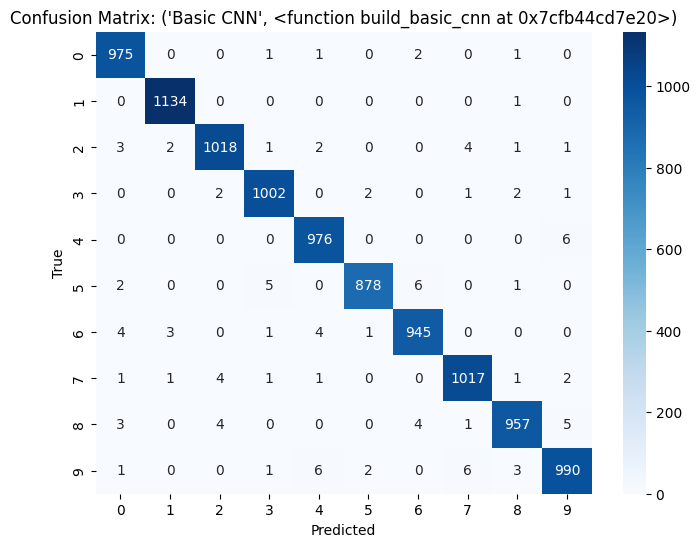


📥 Loading and Evaluating ('CNN with Dropout', <function build_cnn_dropout at 0x7cfb4578c680>)...
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step

📄 Classification Report for ('CNN with Dropout', <function build_cnn_dropout at 0x7cfb4578c680>):
              precision    recall  f1-score   support

           0     0.9858    0.9949    0.9904       980
           1     0.9947    0.9991    0.9969      1135
           2     0.9903    0.9864    0.9883      1032
           3     0.9901    0.9921    0.9911      1010
           4     0.9859    0.9939    0.9899       982
           5     0.9943    0.9843    0.9893       892
           6     0.9875    0.9864    0.9869       958
           7     0.9883    0.9893    0.9888      1028
           8     0.9897    0.9825    0.9861       974
           9     0.9851    0.9812    0.9831      1009

    accuracy                         0.9892     10000
   macro avg     0.9892    0.9890    0.9891     10000
weighted avg     0.9892    0.9892    0.9892     10000



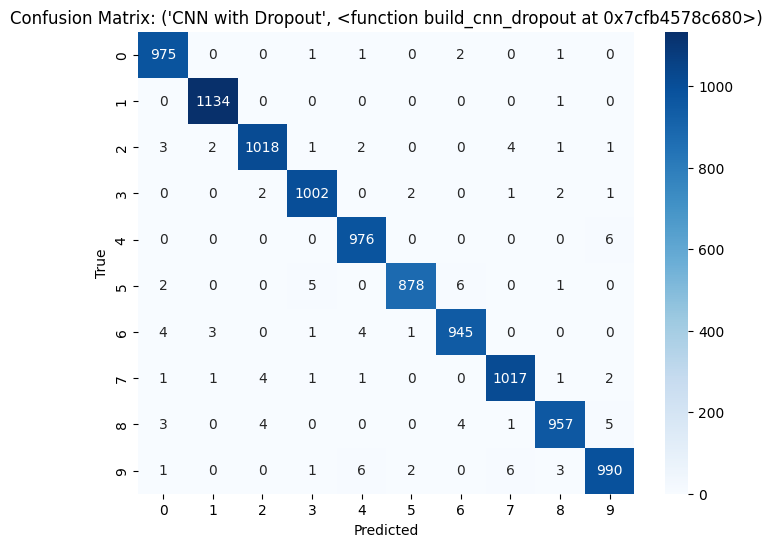


📥 Loading and Evaluating ('CNN with BatchNorm', <function build_cnn_batchnorm at 0x7cfb4578e840>)...
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step

📄 Classification Report for ('CNN with BatchNorm', <function build_cnn_batchnorm at 0x7cfb4578e840>):
              precision    recall  f1-score   support

           0     0.9858    0.9949    0.9904       980
           1     0.9947    0.9991    0.9969      1135
           2     0.9903    0.9864    0.9883      1032
           3     0.9901    0.9921    0.9911      1010
           4     0.9859    0.9939    0.9899       982
           5     0.9943    0.9843    0.9893       892
           6     0.9875    0.9864    0.9869       958
           7     0.9883    0.9893    0.9888      1028
           8     0.9897    0.9825    0.9861       974
           9     0.9851    0.9812    0.9831      1009

    accuracy                         0.9892     10000
   macro avg     0.9892    0.9890    0.9891     10000
weighted avg     0.9892    0.9892    0.9892     10

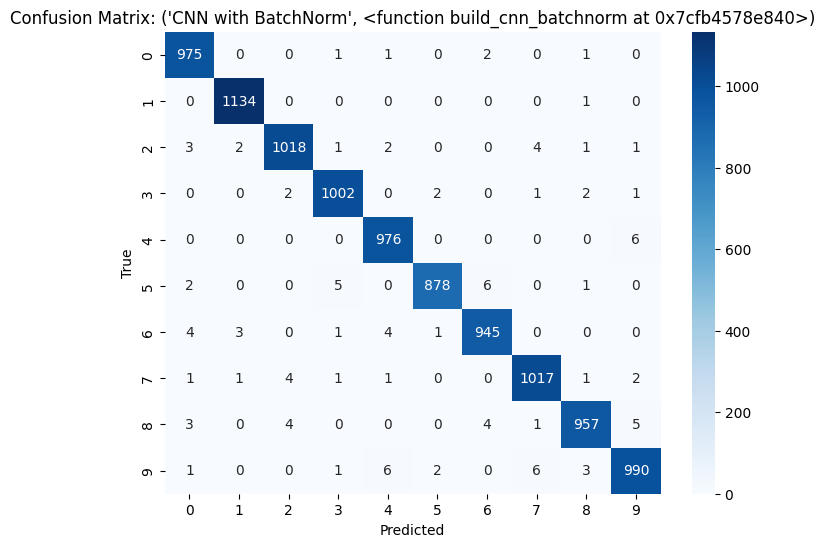


📥 Loading and Evaluating ('Deep VGG-like CNN', <function build_deep_vgg_like at 0x7cfb4578eb60>)...
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step

📄 Classification Report for ('Deep VGG-like CNN', <function build_deep_vgg_like at 0x7cfb4578eb60>):
              precision    recall  f1-score   support

           0     0.9858    0.9949    0.9904       980
           1     0.9947    0.9991    0.9969      1135
           2     0.9903    0.9864    0.9883      1032
           3     0.9901    0.9921    0.9911      1010
           4     0.9859    0.9939    0.9899       982
           5     0.9943    0.9843    0.9893       892
           6     0.9875    0.9864    0.9869       958
           7     0.9883    0.9893    0.9888      1028
           8     0.9897    0.9825    0.9861       974
           9     0.9851    0.9812    0.9831      1009

    accuracy                         0.9892     10000
   macro avg     0.9892    0.9890    0.9891     10000
weighted avg     0.9892    0.9892    0.9892     100

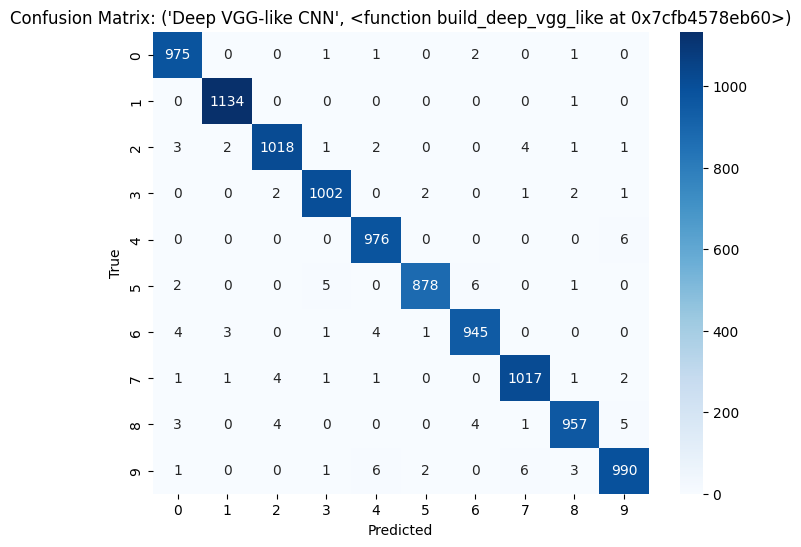


📥 Loading and Evaluating ('MobileNet-style CNN', <function build_mobilenet_like at 0x7cfb4578c720>)...
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step

📄 Classification Report for ('MobileNet-style CNN', <function build_mobilenet_like at 0x7cfb4578c720>):
              precision    recall  f1-score   support

           0     0.9858    0.9949    0.9904       980
           1     0.9947    0.9991    0.9969      1135
           2     0.9903    0.9864    0.9883      1032
           3     0.9901    0.9921    0.9911      1010
           4     0.9859    0.9939    0.9899       982
           5     0.9943    0.9843    0.9893       892
           6     0.9875    0.9864    0.9869       958
           7     0.9883    0.9893    0.9888      1028
           8     0.9897    0.9825    0.9861       974
           9     0.9851    0.9812    0.9831      1009

    accuracy                         0.9892     10000
   macro avg     0.9892    0.9890    0.9891     10000
weighted avg     0.9892    0.9892    0.9892   

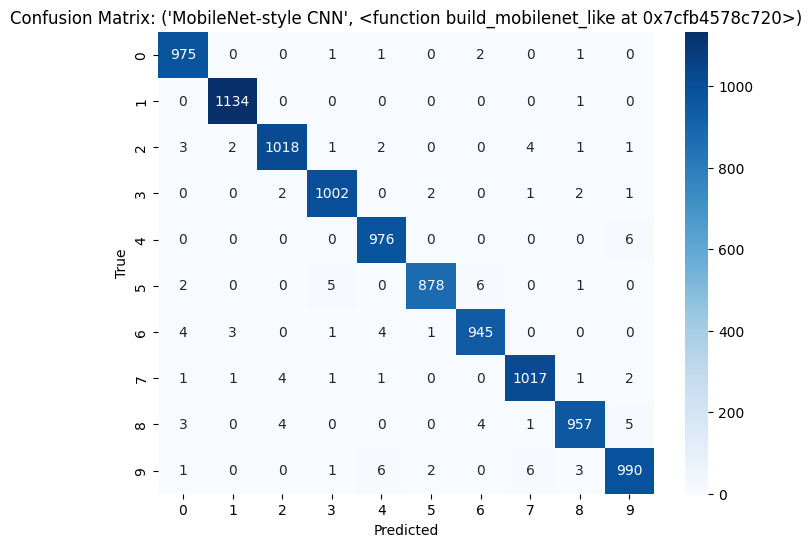

In [54]:
# List of saved model names and display labels

# Evaluation loop
for name in models:
    print(f"\n📥 Loading and Evaluating {name}...")

    # Predictions
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Classification Report
    print(f"\n📄 Classification Report for {name}:")
    print(classification_report(y_true_classes, y_pred_classes, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


Best model is Deep VGG-like CNN

| Model               | Accuracy   | Loss   |
| ------------------- | ---------- | ------ |
| ✅ Deep VGG-like CNN | **0.9927** | 0.0216 |
| MobileNet-style CNN | 0.9892     | 0.0342 |
| CNN with BatchNorm  | 0.9870     | 0.0524 |
| CNN with Dropout    | 0.9861     | 0.0422 |
| Basic CNN           | 0.9836     | 0.0474 |
